In [20]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import scipy.io
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import datasets, layers, optimizers, Sequential, metrics, callbacks

In [21]:
def to_binary(x):
    return np.where(x > 0, 1.0, 0.0).astype(np.uint8)
        
def relu(x):
    return np.where(x > 0, x, 0.0)

def top_k_ids(D, k):
    Di = np.argpartition(D, -k, axis=1)
    if k < 0:
        Di_top = Di[:, :(-k)]
    else:
        Di_top = Di[:, (-k):]
    Dv_top = np.take_along_axis(D, Di_top, axis=1)
    sorted_top = np.argsort(Dv_top, axis=1)
    return np.take_along_axis(
        Di_top, 
        sorted_top if k < 0 else np.flip(sorted_top, axis=1), 
        axis=1
    )

def query_coded(xc, yc, k):
    D = np.asarray([np.sum(ycv ^ xc, axis=1) for ycv in yc])
    return top_k_ids(D, k)

def overlaps(X, Y):
    assert X.shape == Y.shape
    return np.asarray([len(np.intersect1d(x, y)) for x, y in zip(X, Y)])

def shm(*matrices, **kwargs):
    plt.figure(1, figsize=(25,10))
    for m_id, matrix in enumerate(matrices):
        plt.subplot(len(matrices), 1, m_id+1)
        plt.imshow(np.squeeze(matrix).T, cmap='gray', origin='lower')
        plt.colorbar()

    if kwargs.get("file"):
        plt.savefig(kwargs["file"])
        plt.clf()
    else:
        plt.show()

def quality(proposed, gt, number_of_neighbors):
    return np.mean(overlaps(proposed, gt) / number_of_neighbors)

def quality_coded(xc, yc, gt, k):
    return quality(query_coded(xc, yc, k), gt, k)

def norm(w, factor=1.0):
    for i in range(w.shape[1]):
        w[:, i] = factor * w[:, i] / np.sqrt(np.sum(np.square(w[:,i])))
        
def plot_weights(W):
    input_d = int(np.sqrt(W.shape[0]))
    hidden_d = int(np.sqrt(W.shape[1]))

    W_plot = np.zeros((input_d * hidden_d, input_d * hidden_d))
    i = 0
    for y in range(hidden_d):
        for x in range(hidden_d):
            W_plot[
                y*input_d:(y+1)*input_d,
                x*input_d:(x+1)*input_d
            ] = W[:, i].reshape(28,28)
            i += 1
    return shm(W_plot)

def weights_inner_product(W, p):
    return np.asarray([np.linalg.norm(W[:, ni], ord=p) for ni in range(W.shape[1])])

def train_mlp(
    X, 
    Y, 
    Xt, 
    Yt, 
    hidden_layer_size=None, 
    epochs=300,
    init_learning_rate=0.02,
    verbose=0
):
    def read_mnist_tf(X, Y):
        return (
            tf.data.Dataset.from_tensor_slices((X,Y))
                .shuffle(X.shape[0])
                .batch(100)
        )
    
    def scheduler(epoch):
        return init_learning_rate * (1.0 - epoch / epochs)
        
    train_dataset = read_mnist_tf(X, Y)
    test_dataset = read_mnist_tf(Xt, Yt)
    
    if hidden_layer_size is not None:
        model = Sequential([
            layers.Dense(hidden_layer_size, activation='relu'), 
            layers.Dense(Y.shape[1])
        ])
    else:
        model = Sequential([
            layers.Dense(Y.shape[1])
        ])

    model.compile(
        optimizer=optimizers.SGD(init_learning_rate),
        loss=tf.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    model.fit(
        train_dataset, epochs=epochs,
        validation_data=test_dataset,
        validation_steps=2,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=10),
            callbacks.LearningRateScheduler(scheduler)
        ],
        verbose=verbose
    )    
    return max(model.history.history["val_accuracy"])

In [22]:
mat = scipy.io.loadmat('mnist_all.mat')

def read_mnist(mat, label, num_classes=10, subsample=None):
    X = np.zeros((0, 784))
    Y = np.zeros((0, num_classes))
    for i in range(num_classes):
        data = mat[label + str(i)]
        if subsample is not None:
            data = data[:subsample]

        X = np.concatenate((X, data), axis=0)

        Yi = np.zeros((data.shape[0], num_classes))
        Yi[:, i] = 1.0
        Y = np.concatenate((Y, Yi), axis=0)

    X = X / 255.0
    return X.astype(np.float32), Y.astype(np.float32)

X, Y = read_mnist(mat, "train", 10, 500)
Xt, Yt = read_mnist(mat, "test", 10, 500)

In [8]:
train_mlp(X, Y, Xt, Yt, hidden_layer_size=None, verbose=1)

Epoch 1/300
50/50 [==============================] - 1s 21ms/step - loss: 1.9479 - accuracy: 0.4230 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/300
50/50 [==============================] - 0s 8ms/step - loss: 1.3809 - accuracy: 0.7336 - val_loss: 1.2571 - val_accuracy: 0.7800
Epoch 3/300
50/50 [==============================] - 0s 7ms/step - loss: 1.0931 - accuracy: 0.8032 - val_loss: 1.1005 - val_accuracy: 0.7900
Epoch 4/300
50/50 [==============================] - 0s 7ms/step - loss: 0.9280 - accuracy: 0.8248 - val_loss: 1.0457 - val_accuracy: 0.7350
Epoch 5/300
50/50 [==============================] - 0s 8ms/step - loss: 0.8235 - accuracy: 0.8374 - val_loss: 0.7790 - val_accuracy: 0.8450
Epoch 6/300
50/50 [==============================] - 0s 8ms/step - loss: 0.7544 - accuracy: 0.8442 - val_loss: 0.8379 - val_accuracy: 0.8000
Epoch 7/300
50/50 [==============================] - 0s 8ms/step - loss: 0.6999 - accuracy: 0.8520 - val_loss: 0.7640 - val_accuracy: 0.8350
Epoc

0.91

In [9]:
train_mlp(X, Y, Xt, Yt, hidden_layer_size=200, verbose=1)

Epoch 1/300
50/50 [==============================] - 1s 23ms/step - loss: 1.9700 - accuracy: 0.4342 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/300
50/50 [==============================] - 1s 11ms/step - loss: 1.3284 - accuracy: 0.7564 - val_loss: 1.2224 - val_accuracy: 0.7200
Epoch 3/300
50/50 [==============================] - 0s 9ms/step - loss: 0.9634 - accuracy: 0.8188 - val_loss: 1.0098 - val_accuracy: 0.7650
Epoch 4/300
50/50 [==============================] - 0s 9ms/step - loss: 0.7669 - accuracy: 0.8416 - val_loss: 0.8775 - val_accuracy: 0.7650
Epoch 5/300
50/50 [==============================] - 0s 9ms/step - loss: 0.6494 - accuracy: 0.8578 - val_loss: 0.8015 - val_accuracy: 0.7900
Epoch 6/300
50/50 [==============================] - 0s 9ms/step - loss: 0.5803 - accuracy: 0.8690 - val_loss: 0.6690 - val_accuracy: 0.8850
Epoch 7/300
50/50 [==============================] - 0s 9ms/step - loss: 0.5290 - accuracy: 0.8746 - val_loss: 0.7040 - val_accuracy: 0.8150
Epo

0.93

In [6]:
# init_learning_rate = 0.01
init_learning_rate = 0.05
num_hidden = 200
batch_size = 200
prec = 1e-30
delta = 0.4
p = 2.0
k = 2
n = 3
batch_ids = np.arange(batch_size)
number_of_train_batches = X.shape[0] // batch_size
number_of_test_batches = Xt.shape[0] // batch_size

In [18]:
def inner_product(X, Y, W, p):
    return np.asarray([
        [
            np.dot(np.dot(x, np.diag(np.power(np.abs(W[:, ni]), p - 2))), y)
            for x, y in zip(X, Y)
        ]
        for ni in range(W.shape[1])
    ]).T

In [27]:
W = np.random.normal(0.0, 1.0, (X.shape[1], num_hidden))

i = 0
x = X[i*batch_size:(i+1)*batch_size,:]
a = relu(np.dot(x, W))

top_ids = top_k_ids(a, k)

a_deriv = np.zeros((batch_size, num_hidden))
a_deriv[batch_ids, top_ids[:, 0]] = 1.0
a_deriv[batch_ids, top_ids[:, k-1]] = -delta

dW = np.dot(x.T, a_deriv) - np.sum(a_deriv * a, 0, keepdims=True) * W

In [ ]:
epochs = 500
W = np.random.normal(0.0, 1.0, (X.shape[1], num_hidden))

Xa = np.zeros((X.shape[0], num_hidden), dtype=np.float32)
Xta = np.zeros((Xt.shape[0], num_hidden), dtype=np.float32)

for epoch in range(epochs):
    permute_ids = np.random.permutation(X.shape[0])
    X = X[permute_ids, :]
    Y = Y[permute_ids, :]
    
    learning_rate = init_learning_rate * (1-epoch / epochs)

    dW_norm = 0.0
    for i in range(number_of_train_batches):
        x = X[i*batch_size:(i+1)*batch_size,:]
        
        a = relu(np.dot(x, W))
        
        top_ids = top_k_ids(a, k)

        a_deriv = np.zeros((batch_size, num_hidden))
        a_deriv[batch_ids, top_ids[:, 0]] = 1.0
        a_deriv[batch_ids, top_ids[:, k-1]] = -delta
        
        dW = np.dot(x.T, a_deriv) - np.sum(a_deriv * a, 0, keepdims=True) * W

        # denom = np.amax(np.absolute(dW))

        W += learning_rate * dW / batch_size # / np.where(denom > 1e-20, denom, 1e-20)
        dW_norm += np.linalg.norm(dW)

        Xa[i*batch_size:(i+1)*batch_size,:] = a[:]
        
    for i in range(number_of_test_batches):
        xt = Xt[i*batch_size:(i+1)*batch_size,:]
        
        at = relu(np.dot(xt, W))
        
        Xta[i*batch_size:(i+1)*batch_size,:] = at[:]
    
    if (epoch % (epochs // 100)) == 0 or epoch == epochs-1:
        res = train_mlp(Xa, Y, Xta, Yt)
        print("Epoch {}, |dW| = {:.4f}, min(W) = {:.4f}, max(W) = {:.4f}, |W| = {:.4f}, acc = {:.4f}".format(
            epoch, 
            dW_norm / number_of_train_batches,
            np.min(W),
            np.max(W),
            np.mean(weights_inner_product(W, 2)),
            res
        ))


Epoch 0, |dW| = 12733.5881, min(W) = -4.0240, max(W) = 4.1565, |W| = 25.8736, acc = 0.8800
Epoch 5, |dW| = 4458.2825, min(W) = -3.8407, max(W) = 3.8693, |W| = 19.6481, acc = 0.8900
Epoch 10, |dW| = 2994.0116, min(W) = -3.4208, max(W) = 3.5677, |W| = 15.9128, acc = 0.8900
Epoch 15, |dW| = 2196.3720, min(W) = -3.3990, max(W) = 3.2835, |W| = 13.2890, acc = 0.9300
Epoch 20, |dW| = 1707.6197, min(W) = -3.3870, max(W) = 3.2530, |W| = 11.3219, acc = 0.8800
Epoch 25, |dW| = 1376.6932, min(W) = -3.3600, max(W) = 3.2420, |W| = 9.7889, acc = 0.8850
Epoch 30, |dW| = 1148.2989, min(W) = -3.3336, max(W) = 3.2088, |W| = 8.5716, acc = 0.8600
Epoch 35, |dW| = 961.4330, min(W) = -3.3078, max(W) = 3.1359, |W| = 7.5899, acc = 0.8950
Epoch 40, |dW| = 801.3718, min(W) = -3.2868, max(W) = 3.0461, |W| = 6.7858, acc = 0.8700
Epoch 45, |dW| = 697.2448, min(W) = -3.2740, max(W) = 2.9784, |W| = 6.1295, acc = 0.8900
Epoch 50, |dW| = 616.7173, min(W) = -3.2624, max(W) = 2.9130, |W| = 5.5827, acc = 0.8950
Epoch 55, 

Epoch 460, |dW| = 100.8108, min(W) = -2.5840, max(W) = 2.2492, |W| = 1.5181, acc = 0.8450
Epoch 465, |dW| = 102.2295, min(W) = -2.5831, max(W) = 2.2484, |W| = 1.5168, acc = 0.8550
Epoch 470, |dW| = 100.0651, min(W) = -2.5823, max(W) = 2.2477, |W| = 1.5157, acc = 0.8500
Epoch 475, |dW| = 99.9492, min(W) = -2.5816, max(W) = 2.2471, |W| = 1.5148, acc = 0.8650
Epoch 480, |dW| = 99.7035, min(W) = -2.5811, max(W) = 2.2466, |W| = 1.5141, acc = 0.8950
Epoch 485, |dW| = 100.2004, min(W) = -2.5806, max(W) = 2.2462, |W| = 1.5135, acc = 0.8350
Epoch 490, |dW| = 99.5201, min(W) = -2.5803, max(W) = 2.2460, |W| = 1.5131, acc = 0.8650
Epoch 495, |dW| = 99.6195, min(W) = -2.5802, max(W) = 2.2458, |W| = 1.5129, acc = 0.8650
Epoch 499, |dW| = 99.4582, min(W) = -2.5801, max(W) = 2.2458, |W| = 1.5128, acc = 0.8800


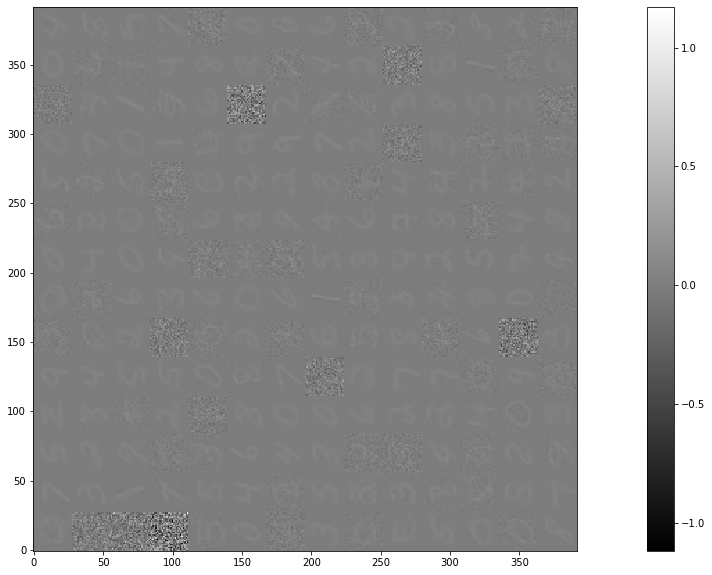

In [45]:
plot_weights(W)